**Fraude en tarjetas de credito.**

Entes financiaros como los bancos, prestan el servicio de expedición de tarjetas de crédito, las cuales son medios de pago que permiten realizar compras, cancelando posteriormente su valor. En ocasiones se presentan fraudes relacionados a estos medios de pago, y estos, generalmente se dividen en 2 categorías: Solicitud fraudulenta de tarjeta y apropiación fraudulenta de cuenta.

En la primera, con los suficientes datos personales de alguien, se realiza la solicitud de expedición de una tarjeta de crédito. En la segunda, con los suficientes datos relacionados a una tarjeta ya existente, se realizan transacciones o compras que dejan consigo una deuda al propietario. En este proyecto nos centraremos en la segunda categoría y en cómo, por medio de datos y técnicas de machine Learning, se pueden identificar.

**Objetivo**

Por medio de técnicas de machine Learning y procesamiento de datos, generar un modelo que, apartir de variables relacionadas a una transacción realizada con trajeta de crédito, sea capáz de identificar posibles casos de fraude, sirviendo a la entidad financiera como alarma para tomar las acciones pertinentes de manera rápida.

**Entendimiento y descripción de los datos.**

Se trabajará con un dataset alojado en Kaggel, el cual contiene transacciones hechas con tarjetas de credito en Septiembre de 2013 por propietarios europeos. Dicho dataset fuer recolectado y analizado por el grupo de Machine Learning (http://mlg.ulb.ac.be) de ULB (Université Libre de Bruxelles). 

En cuanto a la estructura del dataset, se cuenta con 284807 samples etiquetados como fraude (1) y sin fraude(0). El dataset se encuentra fuertemente desbalanceado, siendo la clase predominante la clase 0, con 98% de los ejemplos. 

En cuanto a las features disponibles, por la naturaleza de la información que trabaja el dataset, no se dispone de los nombres de 28 de las 31 variables y a su vez, se les aplicó PCA. 

Aunque esto puede restar interpretabilidad a los resultados y al análisis exploratorio de variables al no estar en el dominio de las variables reales del problema, se escoge este dataset por 2 motivos:

*   En kaggel se citan papers (9) que utilizan este dataset para
abordar el problema de deteccion de fraude en tarjetas de crédito, lo que sugiere que es un set adecuado para tratar con este problema desde el ambito investigativo.

*   El dataset proviene de datos reales analizados por  Université Libre de Bruxelles, por lo que se tiene un set que contiene distribuciones que se encuentran en campo.







In [301]:
#Librerias necesarias

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sk

#Modelos a explorar
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

#Metricas usadas
from sklearn.metrics import make_scorer,recall_score, precision_score, confusion_matrix, average_precision_score, confusion_matrix

import warnings

from math import ceil

warnings.simplefilter(action="ignore")

%matplotlib inline

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (10, 5)


**Versiones de librerías**


*   **Mathplotlib** 3.2.2
*   **Numpy** 1.19.5
*   **Pandas** 1.1.5
*   **Scikitlearn** 0.22.2.post1






In [ ]:
#Funciones y clases requeridas

rf_d = {"random_state": 123, "criterion": "gini"}
mlp_d = {"random_state": 1234, "solver": "adam", "learning_rate": "constant","learning_rate_init": 0.0008, "max_iter": 1000,"n_iter_no_change": 30}

def dataFaltante(dataSet):
    '''
    Funcion que retorna informacion referente a data faltante de un dataset, en forma de string
    dataset: Objeto de tipo panda.DataFrame
    '''
    str_p = ""
    for col in dataSet:
        a = dataSet[col].isnull().sum()
        if a > 0:
            str_p += f"\nCol {str(col)}:\n\t Faltantes: {a}, Porcentaje: {a/dataSet.shape[0]}"
        if str_p == "":
            str_p = "Dataset no tiene datos en blanco"
    return str_p

def porcentajeClases(targetsSerie):
    '''
    retorna objeto tipo <pandas.DataFrame> con el conteo de elementos y su porcentaje con respecto a 
    targetsSeries.shape[0]
    targetsSeries: Elemento tipo <pandas.Series> que contiene etiquetas
    '''
    s1 = targetsSerie.value_counts().rename("Elementos por clase")
    s2 = pd.Series(
        data=[(x/targetsSerie.shape[0])*100 for x in targetsSerie.value_counts()], 
        index=list(s1.index),
        name="Porcentaje")
    
    return pd.concat([s1, s2], axis=1)

def showBoxPlots(dataFrame, features=None):
    '''
    Funcion que muestra diagrama de caja y bigotes para las caracteristicas contenidas en un dataset. Si no
    se suministra el parámetro features, se mostrará un diagrama para cada feature.
    dataFrame: Objeto <pandas.DataFrame> que contiene las caracteristicas.
    features: Objeto <List> que contiene los nombres de las caracteristicas a mostrar.
    '''
    def particion(feat):
        if len(feat)>3:
            return (ceil(len(feat)/3), 3)
        else:
            return (1,3)
    if features == None:
        features = dataFrame.keys()
        
    tp = particion(features)
    l = 5 * tp[0] 
    fig = plt.figure(figsize=(12, l))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(tp[0],tp[1],i+1)
        sns.violinplot(x=dataFrame[feature], ax=ax)
        plt.grid()
    plt.show()
    
class data_gridsearch:
    '''
    Clase encargada de entregar datos a constructor de objeto <sklearn.model_selection.GridSearchCV>
    '''
    def __init__(self, cv=3, scoring="average_precision", verbose=2, refit=True):
        self.estimator = None
        self.param_grid = None
        self.scoring = scoring
        self.cv = cv
        self.verbose = verbose
        self.refit = refit
        
    def to_dict(self):
        '''
        Retorna diccionario para ser usado en el constructor de objeto <sklearn.model_selection.GridSearchCV>
        '''
        return {"estimator": self.estimator, "param_grid": self.param_grid, "scoring": self.scoring, "cv": self.cv, "verbose": self.verbose, "refit": self.refit}
    
def FPR_(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print(f"M:{cm}\n")
    return 1-(cm[0,0]/(cm[0,0]+cm[0,1])) #1 

def show_best_results(clf, n):
    '''
    Funcion que genera dataFrame con los n mejores clasificadores segun la metrica dispuesta en <Refit>
    de objeto <GridSearch>
    '''
    dfs = pd.DataFrame(clf.cv_results_)
    t = dfs[dfs["rank_test_average_p"] < n]
    filter_col = [col for col in t if col.startswith("mean")]
    filter_col.append("rank_test_average_p")
    
    return t[filter_col].sort_values("rank_test_average_p")

def bestResultsRecallPres(clf, min_rec, min_pres):

    dfs = pd.DataFrame(clf.cv_results_)
    t = dfs[np.logical_and(dfs["mean_test_prec"] > min_pres, dfs["mean_test_rec"] > min_rec)]
    filter_col = [col for col in t if col.startswith("mean")]
    filter_col.append("rank_test_average_p")
    
    return t[filter_col].sort_values("rank_test_average_p")

def return_params(dataSet_results, pos, rank="rank_test_average_p"):
    '''
    Retorna parámetros obtenidos por gridsearch como diccionario para usar en construtor de un modelo
    dataSet_results: DataFrame que contiene resultados de GridSearch
    rank: Nombre de columna con respecto a la cual se quieren tomar los datos
    pos: Posicion del clasificador en la columna Rank
    '''
    filter_col = [col for col in dataSet_results if col.startswith("param_")]
    data = dataSet_results[dataSet_results["rank_test_average_p"] == pos][filter_col]
    my_dict = {}
    for i, col in enumerate(data.keys(), 0):
      num = col.index("__")
      new_col = col[num+2:]
      my_dict[new_col] = data.iloc[0,i]
    return my_dict 

def show_metrics(y_true, y_pred):
    '''
    Retorna Precision, recall y average precision dados los arrays de entrada
    '''
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    av = average_precision_score(y_true, y_pred)
    m = confusion_matrix(y_true, y_pred)
    return prec, rec, av, m

def plot_metrics(dataSet_results, rank_to_order="rank_test_average_p", clf_name = "", q = 10, showValue=True):
    '''
    Gráfica de metricas de desempeño almacenadas en dataSet_results, y ordenadas en eje X de acuerdo a rank_to_order
    dataSet_results: Objeto de tipo <pandas.DataFrame> resultante de clf.cv_results_
    rank_to_order: String asociado a nombre de columna presente en dataSet_results, por medio de la cual se organizará
      el dataset de entrada para visualizacion de metricas de los clasificadores. Se aconseja usar una columna con nombre
      iniciado por "rank", para tener un orden logico en eje X de la gráfica
    q: Numero de clasificadores a mostrar con mejor puntaje en rank_to_order
    '''
    def true_name(name):
      if name == "average_p":
        return "Average precision"
      elif name == "prec":
        return "Precision"
      elif name == "rec":
        return "Recall"
      else:
        return "FPR"

    mean_v = [col for col in dataSet_results if col.startswith("mean_test_") and not col.endswith(rank_to_order.replace("rank_test",""))]

    data = dataSet_results.sort_values(rank_to_order)[:q+1]

    x_to_plot = data[rank_to_order]
    flag = showValue
    fig, ax = plt.subplots()
    ax.set(title=f"Metricas de desempeño clasificador {clf_name}", xlabel=f"Ranking de acuerdo a {rank_to_order.replace('rank_test_','')}", ylabel="Valor de métrica")
    for metric in mean_v:
      ax.plot(x_to_plot, data[metric], label=true_name(metric.replace("mean_test_","")), marker="o",linestyle=":", markersize=2)
      if flag:
        flag = False
        for x, value in zip(x_to_plot, data[rank_to_order.replace("rank", "mean")]):   #data[rank_to_order]  
          ax.annotate(f"V:{value:.3f}",
                      xy=(x, 0.97),
                      xycoords='data',
                      xytext=(x, 0.97),
                      textcoords='data',
                      fontsize=6
                      )

    
    
    legend = ax.legend(loc='best', fontsize='large')
    legend.get_frame()
    ax.grid(True)
    ax.set_xticks(x_to_plot)
    ax.set_yticks(np.linspace(0,1,21))
    fig.show()
    return data[[rank_to_order,'mean_test_average_p', 'std_test_average_p', 'mean_test_rec', 'std_test_rec', 'mean_test_prec', 'std_test_prec','mean_test_FPR', 'std_test_FPR']]


In [ ]:
#Se trae dataset alojado en GoogleDrive. Nombre: creditcard.csv

!gdown --id 1WINdeQEoz6qlFkdxfXQLnLkyXYmyAzDQ

Downloading...
From: https://drive.google.com/uc?id=1WINdeQEoz6qlFkdxfXQLnLkyXYmyAzDQ
To: /content/creditcard.csv
100% 151M/151M [00:01<00:00, 119MB/s] 


In [ ]:
#carga de dataset a ambiente
dataSet = pd.read_csv("creditcard.csv")

In [ ]:
#Informacion basica del set:

print(f"Número de caracteristicas: {dataSet.shape[1]}\n")
print(f"Número de ejemplos:        {dataSet.shape[0]}\n")
print(f"Tipos de datos presentes(columnas):\n\n{dataSet.dtypes.value_counts()}\n")
print(f"Data faltante:\n{dataFaltante(dataSet)}\n")
print(f"Registros duplicados:\n{dataSet.duplicated().sum()}\n")

Número de caracteristicas: 31

Número de ejemplos:        283726

Tipos de datos presentes(columnas):

float64    30
int64       1
dtype: int64

Data faltante:
Dataset no tiene datos en blanco

Registros duplicados:
0



In [ ]:
#Eliminar registros no utiles
dataSet.drop_duplicates(keep="first", inplace=True, ignore_index=False)
print(f"Número de caracteristicas: {dataSet.shape[1]}\n")
print(f"Número de ejemplos:        {dataSet.shape[0]}\n")

#Revision de info:
dataSet.info()


Número de caracteristicas: 31

Número de ejemplos:        283726

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283726 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    283726 non-null  float64
 1   V1      283726 non-null  float64
 2   V2      283726 non-null  float64
 3   V3      283726 non-null  float64
 4   V4      283726 non-null  float64
 5   V5      283726 non-null  float64
 6   V6      283726 non-null  float64
 7   V7      283726 non-null  float64
 8   V8      283726 non-null  float64
 9   V9      283726 non-null  float64
 10  V10     283726 non-null  float64
 11  V11     283726 non-null  float64
 12  V12     283726 non-null  float64
 13  V13     283726 non-null  float64
 14  V14     283726 non-null  float64
 15  V15     283726 non-null  float64
 16  V16     283726 non-null  float64
 17  V17     283726 non-null  float64
 18  V18     283726 non-null  float64
 19  V19     283726 non-n

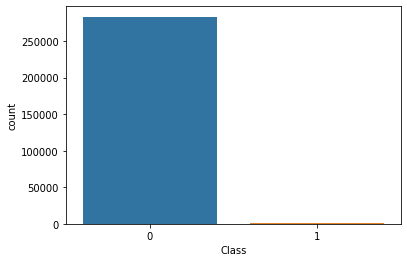

Revision de etiquetas:
    Elementos por clase  Porcentaje
0               283253    99.83329
1                  473     0.16671


In [ ]:
#Revision de dominio de las variables y etiquetas:

#Etiquetas:
sns.countplot(data=dataSet, x="Class")
plt.show()
#Porcentaje de ejemplos por clase:
print(f"Revision de etiquetas:\n {porcentajeClases(dataSet['Class'])}")

**Exploración de datos**

Se exploran rangos y distribuciones de densidad para cada variable.

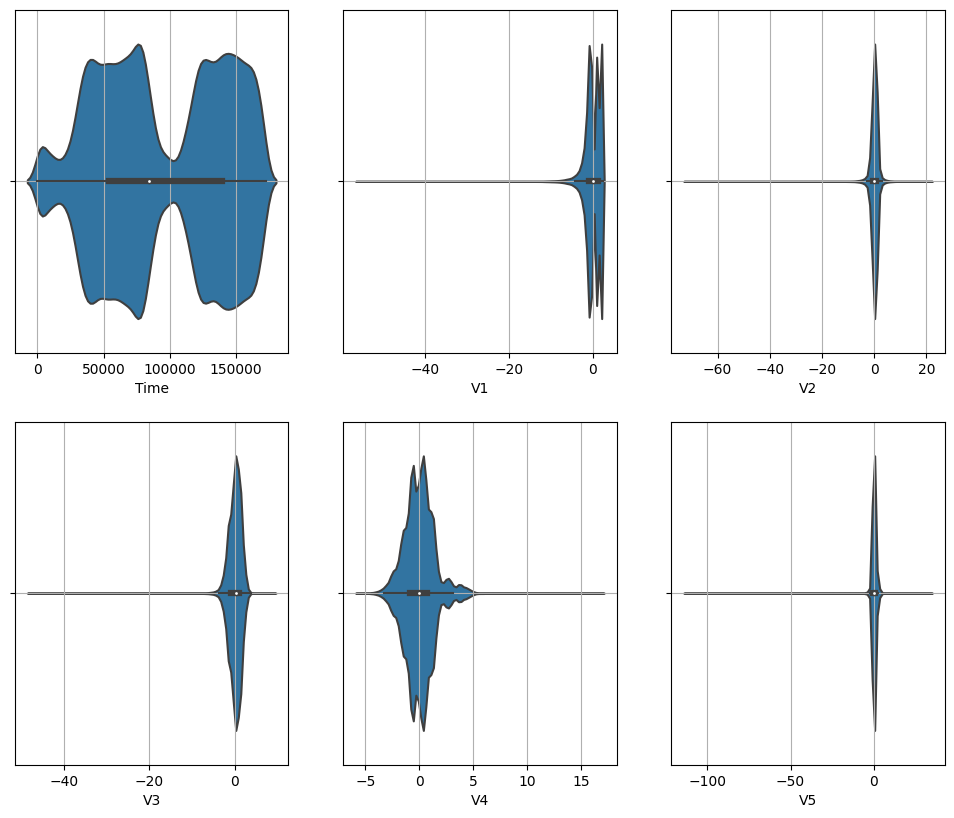

In [ ]:
#revision de features: Time', 'V1', 'V2', 'V3', 'V4', 'V5'
showBoxPlots(dataSet, ['Time', 'V1', 'V2', 'V3', 'V4', 'V5'])

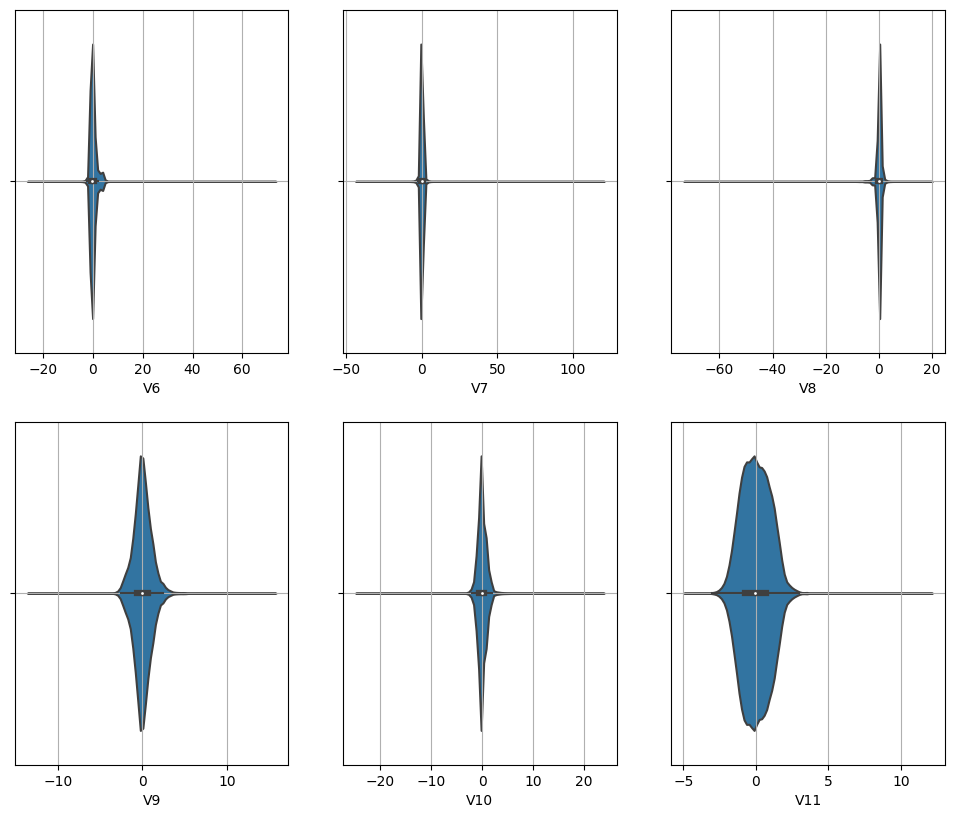

In [ ]:
#revision de features: 'V6', 'V7', 'V8', 'V9', 'V10','V11'
showBoxPlots(dataSet, ['V6', 'V7', 'V8', 'V9', 'V10','V11'])

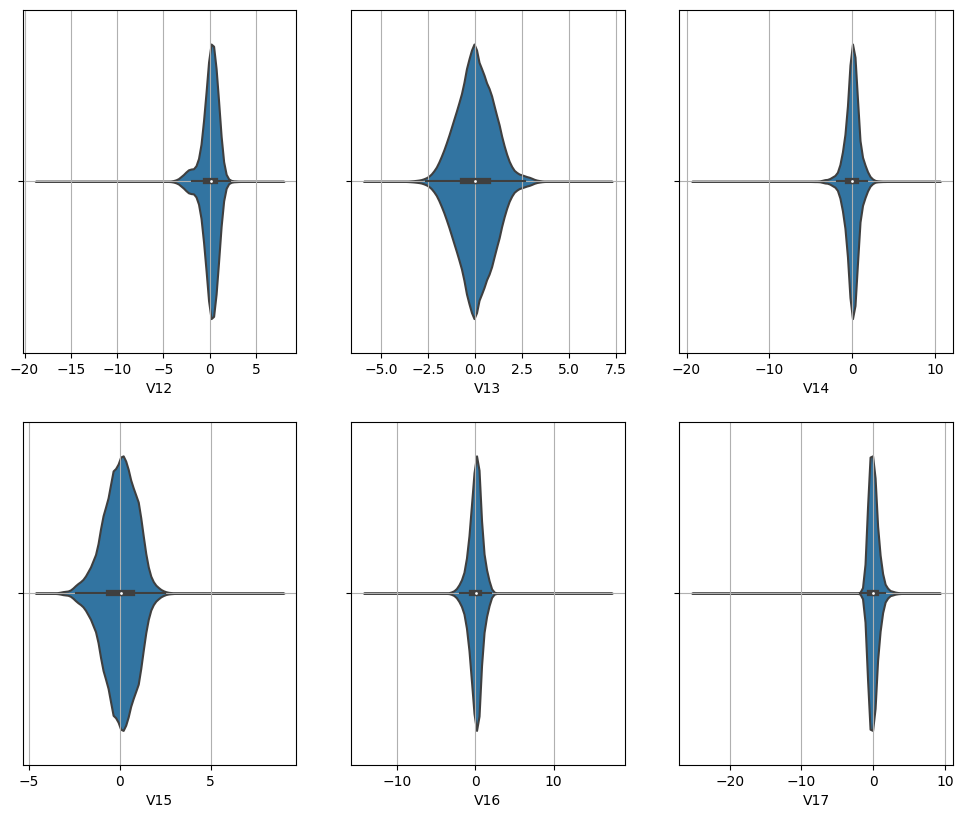

In [ ]:
#revision de features: 'V12', 'V13', 'V14', 'V15', 'V16', 'V17'
showBoxPlots(dataSet, ['V12', 'V13', 'V14', 'V15', 'V16', 'V17'])

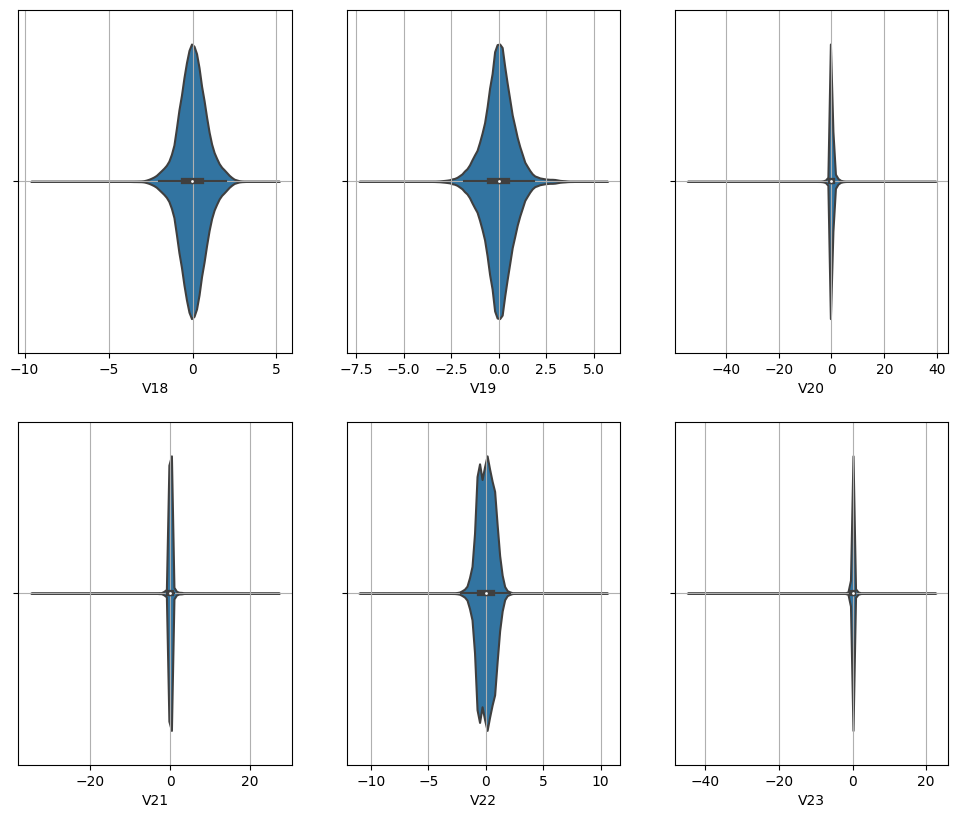

In [ ]:
#revision de features: 'V18', 'V19', 'V20', 'V21', 'V22', 'V23'
showBoxPlots(dataSet, ['V18', 'V19', 'V20', 'V21', 'V22', 'V23'])

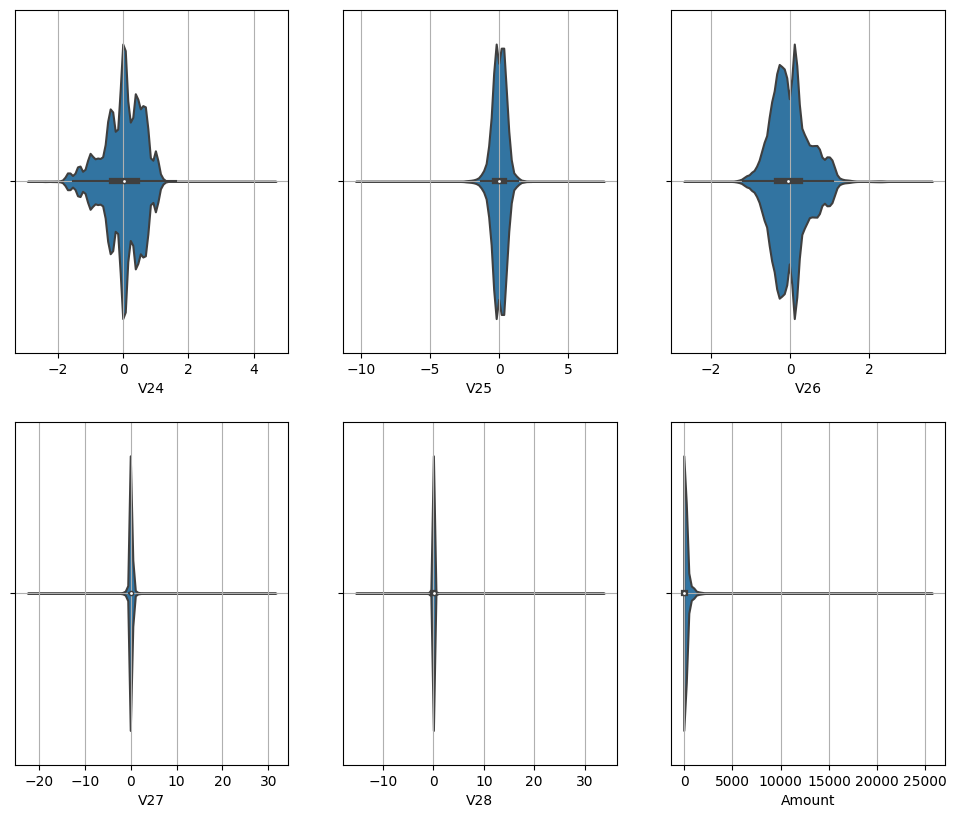

In [ ]:
#revision de features: 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'
showBoxPlots(dataSet, ['V24', 'V25', 'V26', 'V27', 'V28', 'Amount'])

Describe para Categoria 0, segun monto

count    283253.000000
mean         88.413575
std         250.379023
min           0.000000
25%           5.670000
50%          22.000000
75%          77.460000
max       25691.160000
Name: Amount, dtype: float64

Describe para Categoria 1, segun monto

count     473.000000
mean      123.871860
std       260.211041
min         0.000000
25%         1.000000
50%         9.820000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64



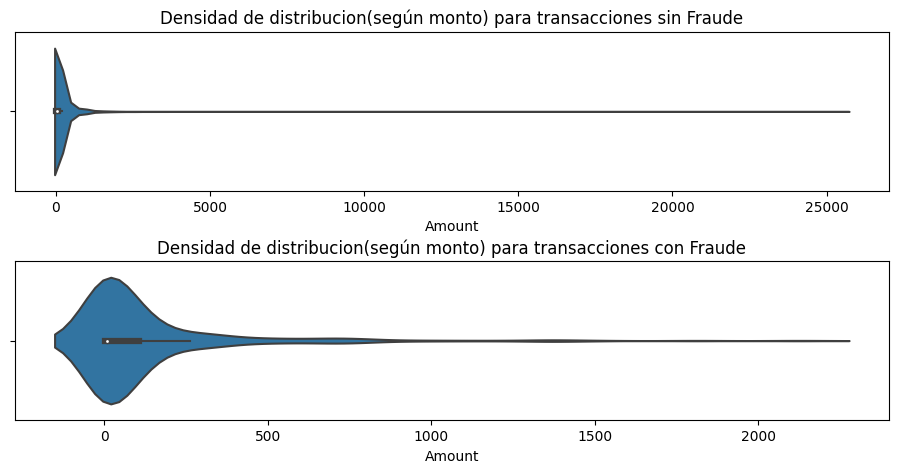

In [ ]:
#Montos en situaciones de fraude:
#sns.violinplot(x="Class", y="Amount", data=dataSet, scale="count")
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.tight_layout(pad=3.0)

ax[0].set_title("Densidad de distribucion(según monto) para transacciones sin Fraude")
ax[1].set_title("Densidad de distribucion(según monto) para transacciones con Fraude")
am0 = dataSet["Amount"][dataSet["Class"] == 0]
am1 = dataSet["Amount"][dataSet["Class"] == 1]
sns.violinplot(x=am0, ax=ax[0])
print(f"Describe para Categoria 0, segun monto\n\n{am0.describe()}\n")
print(f"Describe para Categoria 1, segun monto\n\n{am1.describe()}\n")
sns.violinplot(x=am1, ax=ax[1])
plt.show()
del am0, am1

In [ ]:
#Procesamiento manual de datos
X = dataSet.drop(labels=["Time","Class"], axis = 1)
y = dataSet["Class"]
print(f"Tamaño X: {X.shape}")
print(f"Tamaño y: {y.shape}")

Tamaño X: (283726, 29)
Tamaño y: (283726,)


In [ ]:
#Particionamiento en prueba y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234, stratify=y)
print(f"Particiones:\n\n## Entrenamiento ##\n\tX: {X_train.shape}\n\ty: {y_train.shape}\nEjemplos por clase:\n{y_train.value_counts()}\n\n## Prueba ##\n\tX: {X_test.shape}\n\ty: {y_test.shape}\nEjemplos por clase:\n{y_test.value_counts()}")

Particiones:

## Entrenamiento ##
	X: (198608, 29)
	y: (198608,)
Ejemplos por clase:
0    198277
1       331
Name: Class, dtype: int64

## Prueba ##
	X: (85118, 29)
	y: (85118,)
Ejemplos por clase:
0    84976
1      142
Name: Class, dtype: int64


In [ ]:
#Objetos comunes para los estimadores a explorar

dict_scoring = {"FPR": make_scorer(FPR_, greater_is_better=True),
                "rec": "recall",
                "prec": "precision",
                "average_p" : "average_precision"
               }

sc = ("columTransformer", ColumnTransformer([("standard", StandardScaler(), ["Amount"])], remainder="passthrough"))

data_svc = data_gridsearch(verbose=3)
data_svc.scoring = dict_scoring
data_svc.refit = "average_p"

**Métricas**

La métrica que se trabaja para el ranking de clasificadores será **average precision** debido a que por medio de ella podemos ver la maximización de **recall** y **precision**, las cuales son muy importantes en ésta aplicación, y además, es una métrica válida para problemas con un desbalance de clases tan notorio.

**Clasificadores**

Se trabajarán:


*   Random Forest
*   Logistic regression
*   MLP Classifier

Por temas de tiempos de ejecución demasiado prolongados (debido a tamaño del dataset) no se realizó exploración con **SVC**, aún así al final del notebook se tiene la implementación de un Pipeline con este clasificador.




In [ ]:
#Pipeline y GridSearch para estimador: LogisticRegression

data_svc.estimator = Pipeline(steps=[sc,("LogReg",LogisticRegression(random_state=1234, max_iter=200))])
data_svc.param_grid = {"LogReg__C": [10**x for x in range(-1,3)], #4 valores
                       "LogReg__solver": ["lbfgs", "sag"], #2 Valores
                       "LogReg__class_weight": [{1: w} for w in range(1, 200, 50)] #4valores
                      }

print(f"Comienza\n")

gr = GridSearchCV(**data_svc.to_dict())
gr.fit(X_train, y_train)

print("\nTerminado")

Comienza

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] LogReg__C=0.1, LogReg__class_weight={1: 1}, LogReg__solver=lbfgs 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


M:[[66083    10]
 [   41    69]]

[CV]  LogReg__C=0.1, LogReg__class_weight={1: 1}, LogReg__solver=lbfgs, FPR=0.000, average_p=0.731, prec=0.873, rec=0.627, total=   2.0s
[CV] LogReg__C=0.1, LogReg__class_weight={1: 1}, LogReg__solver=lbfgs 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


M:[[66083     9]
 [   47    64]]

[CV]  LogReg__C=0.1, LogReg__class_weight={1: 1}, LogReg__solver=lbfgs, FPR=0.000, average_p=0.750, prec=0.877, rec=0.577, total=   2.0s
[CV] LogReg__C=0.1, LogReg__class_weight={1: 1}, LogReg__solver=lbfgs 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


M:[[66081    11]
 [   43    67]]

[CV]  LogReg__C=0.1, LogReg__class_weight={1: 1}, LogReg__solver=lbfgs, FPR=0.000, average_p=0.747, prec=0.859, rec=0.609, total=   1.9s
[CV] LogReg__C=0.1, LogReg__class_weight={1: 1}, LogReg__solver=sag ..
M:[[66084     9]
 [   45    65]]

[CV]  LogReg__C=0.1, LogReg__class_weight={1: 1}, LogReg__solver=sag, FPR=0.000, average_p=0.725, prec=0.878, rec=0.591, total=  18.2s
[CV] LogReg__C=0.1, LogReg__class_weight={1: 1}, LogReg__solver=sag ..
M:[[66084     8]
 [   47    64]]

[CV]  LogReg__C=0.1, LogReg__class_weight={1: 1}, LogReg__solver=sag, FPR=0.000, average_p=0.750, prec=0.889, rec=0.577, total=  17.8s
[CV] LogReg__C=0.1, LogReg__class_weight={1: 1}, LogReg__solver=sag ..
M:[[66082    10]
 [   43    67]]

[CV]  LogReg__C=0.1, LogReg__class_weight={1: 1}, LogReg__solver=sag, FPR=0.000, average_p=0.754, prec=0.870, rec=0.609, total=  17.8s
[CV] LogReg__C=0.1, LogReg__class_weight={1: 51}, LogReg__solver=lbfgs 
M:[[66008    85]
 [   20    90]]

[CV

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed: 16.6min finished



Terminado


In [ ]:
#DataFrame con los n mejores resultados para LogisticRegression

gs_LR = gr # Si se ejecuta luego de realizar entrenamiento con otro conjunto anterior, se sobreescribe info
show_best_results(gs_LR, show)

,mean_fit_time,mean_score_time,mean_test_FPR,mean_test_rec,mean_test_prec,mean_test_average_p,rank_test_average_p
25,17.462542,0.217490,0.000136,0.592192,0.879132,0.743470,1
17,17.008093,0.217210,0.000136,0.592192,0.879132,0.743458,2
9,17.050403,0.218860,0.000136,0.592192,0.879132,0.743153,3
1,17.711555,0.221940,0.000136,0.592192,0.879132,0.742714,4
0,1.746769,0.224323,0.000151,0.604313,0.869701,0.742677,5
8,2.585377,0.219489,0.000166,0.604341,0.857991,0.740795,6
16,3.389590,0.218898,0.000171,0.613377,0.856267,0.740596,7
24,3.322136,0.217087,0.000166,0.616407,0.860393,0.740584,8
7,17.517455,0.222755,0.006037,0.864019,0.195414,0.737852,9
29,17.406352,0.215306,0.003697,0.848922,0.285161,0.735612,10


,rank_test_average_p,mean_test_average_p,std_test_average_p,mean_test_rec,std_test_rec,mean_test_prec,std_test_prec,mean_test_FPR,std_test_FPR
25,1,0.743470,0.012764,0.592192,0.013305,0.879132,0.007677,0.000136,0.000012
17,2,0.743458,0.012786,0.592192,0.013305,0.879132,0.007677,0.000136,0.000012
9,3,0.743153,0.012530,0.592192,0.013305,0.879132,0.007677,0.000136,0.000012
1,4,0.742714,0.012729,0.592192,0.013305,0.879132,0.007677,0.000136,0.000012
0,5,0.742677,0.008363,0.604313,0.020971,0.869701,0.007704,0.000151,0.000012
8,6,0.740795,0.006726,0.604341,0.028286,0.857991,0.014306,0.000166,0.000012
16,7,0.740596,0.006441,0.613377,0.024629,0.856267,0.014428,0.000171,0.000014
24,8,0.740584,0.006465,0.616407,0.028624,0.860393,0.013873,0.000166,0.000012
7,9,0.737852,0.016859,0.864019,0.007895,0.195414,0.024137,0.006037,0.000815
29,10,0.735612,0.017766,0.848922,0.008896,0.285161,0.051547,0.003697,0.000815


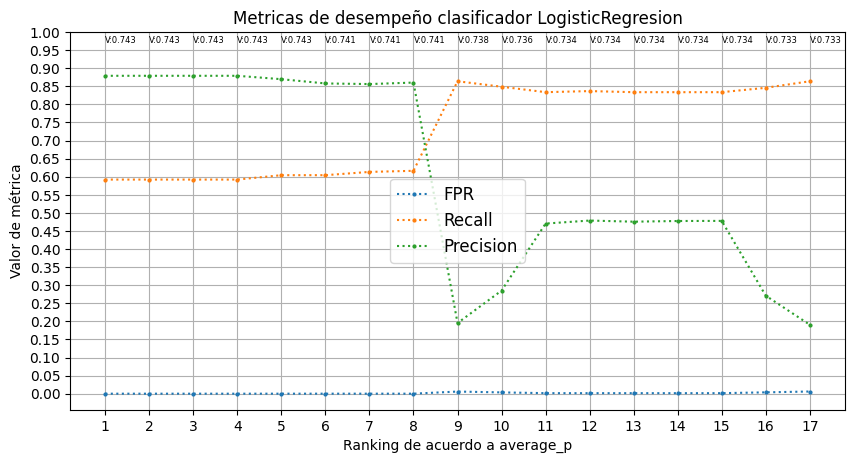

In [ ]:
#Metricas para N clasificadores LogisticRegresion
show = 16
plot_metrics(pd.DataFrame(gs_LR.cv_results_), clf_name="LogisticRegresion", q=show)

In [ ]:
#Pipeline y GridSearch para estimador: RandomForest 

data_svc.estimator = Pipeline(steps=[sc,("rForest", RandomForestClassifier(random_state=123, criterion="gini"))])
data_svc.param_grid = {"rForest__n_estimators": [20, 30, 40, 50], #4 valores
                       "rForest__class_weight": [{0: 1, 1: w} for w in range(1, 200, 50)], #4valores
                       "rForest__max_depth": [4, 8, 16, 32, 64] #5valores
                      }

print(f"Comienza\n")

gr = GridSearchCV(**data_svc.to_dict())
gr.fit(X_train, y_train)

print("\nTerminado")

Comienza

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV] rForest__class_weight={0: 1, 1: 1}, rForest__max_depth=4, rForest__n_estimators=20 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


M:[[66083    10]
 [   38    72]]

[CV]  rForest__class_weight={0: 1, 1: 1}, rForest__max_depth=4, rForest__n_estimators=20, FPR=0.000, average_p=0.739, prec=0.878, rec=0.655, total=   7.3s
[CV] rForest__class_weight={0: 1, 1: 1}, rForest__max_depth=4, rForest__n_estimators=20 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s


M:[[66086     6]
 [   39    72]]

[CV]  rForest__class_weight={0: 1, 1: 1}, rForest__max_depth=4, rForest__n_estimators=20, FPR=0.000, average_p=0.801, prec=0.923, rec=0.649, total=   7.3s
[CV] rForest__class_weight={0: 1, 1: 1}, rForest__max_depth=4, rForest__n_estimators=20 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.6s remaining:    0.0s


M:[[66084     8]
 [   33    77]]

[CV]  rForest__class_weight={0: 1, 1: 1}, rForest__max_depth=4, rForest__n_estimators=20, FPR=0.000, average_p=0.809, prec=0.906, rec=0.700, total=   7.2s
[CV] rForest__class_weight={0: 1, 1: 1}, rForest__max_depth=4, rForest__n_estimators=30 
M:[[66082    11]
 [   40    70]]

[CV]  rForest__class_weight={0: 1, 1: 1}, rForest__max_depth=4, rForest__n_estimators=30, FPR=0.000, average_p=0.747, prec=0.864, rec=0.636, total=  10.7s
[CV] rForest__class_weight={0: 1, 1: 1}, rForest__max_depth=4, rForest__n_estimators=30 
M:[[66085     7]
 [   40    71]]

[CV]  rForest__class_weight={0: 1, 1: 1}, rForest__max_depth=4, rForest__n_estimators=30, FPR=0.000, average_p=0.802, prec=0.910, rec=0.640, total=  10.8s
[CV] rForest__class_weight={0: 1, 1: 1}, rForest__max_depth=4, rForest__n_estimators=30 
M:[[66085     7]
 [   31    79]]

[CV]  rForest__class_weight={0: 1, 1: 1}, rForest__max_depth=4, rForest__n_estimators=30, FPR=0.000, average_p=0.808, prec=0.919, re

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 106.9min finished



Terminado


In [ ]:
#DataFrame con los n mejores resultados para RandomForest

gs_RF = gr # Si se ejecuta luego de realizar entrenamiento con otro conjunto anterior, se sobreescribe info
show_best_results(gs_RF, show)

#dfs = pd.DataFrame(gr.cv_results_)
#t = dfs[dfs["rank_test_average_p"] < 15].sort_values("rank_test_average_p")
#t

,mean_fit_time,mean_score_time,mean_test_FPR,mean_test_rec,mean_test_prec,mean_test_average_p,rank_test_average_p
0,6.972560,0.274407,0.000121,0.667731,0.902336,0.782988,1
1,10.376933,0.344200,0.000126,0.664728,0.897686,0.785788,2
2,13.800232,0.421143,0.000121,0.670734,0.901819,0.786600,2
3,17.184180,0.481198,0.000126,0.670734,0.898180,0.787638,4
4,13.424294,0.321800,0.000071,0.746219,0.946360,0.820625,5
5,20.116481,0.408452,0.000066,0.749304,0.950472,0.821739,6
6,26.920024,0.503345,0.000066,0.752280,0.950493,0.821630,7
7,33.773007,0.595175,0.000066,0.752280,0.950488,0.822851,7
8,22.657194,0.411059,0.000061,0.761316,0.954662,0.826861,9
9,34.050802,0.540507,0.000055,0.761343,0.958109,0.828514,10


,rank_test_average_p,mean_test_average_p,std_test_average_p,mean_test_rec,std_test_rec,mean_test_prec,std_test_prec,mean_test_FPR,std_test_FPR
0,1,0.782988,0.031463,0.667731,0.022944,0.902336,0.018553,0.000121,0.000025
1,2,0.785788,0.027560,0.664728,0.037821,0.897686,0.023924,0.000126,0.000029
2,2,0.786600,0.026361,0.670734,0.041859,0.901819,0.020288,0.000121,0.000021
3,4,0.787638,0.025093,0.670734,0.041859,0.898180,0.025393,0.000126,0.000029
4,5,0.820625,0.012699,0.746219,0.007501,0.946360,0.010837,0.000071,0.000014
5,6,0.821739,0.013593,0.749304,0.014330,0.950472,0.013259,0.000066,0.000019
6,7,0.821630,0.012250,0.752280,0.008085,0.950493,0.013893,0.000066,0.000019
7,7,0.822851,0.011971,0.752280,0.008085,0.950488,0.010357,0.000066,0.000014
8,9,0.826861,0.009547,0.761316,0.004866,0.954662,0.008615,0.000061,0.000012
9,10,0.828514,0.011321,0.761343,0.015196,0.958109,0.005803,0.000055,0.000007


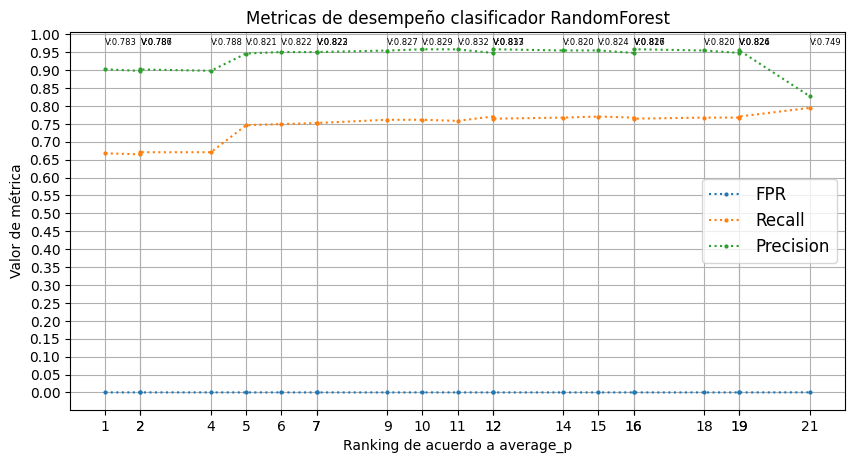

In [ ]:
#Metricas para N clasificadores RandomForest
show = 20
plot_metrics(pd.DataFrame(gs_RF.cv_results_), clf_name="RandomForest", q=show)

In [ ]:
#Pipeline y GridSearch para estimador: MLPClassifier

data_svc.estimator = Pipeline(steps=[sc,("NR",MLPClassifier(random_state=1234,
                                                                solver="adam",
                                                                learning_rate="constant",
                                                                learning_rate_init=0.0008,
                                                                max_iter=1000,
                                                                n_iter_no_change=30))])
data_svc.param_grid = {"NR__hidden_layer_sizes": [(20,5),(20,10),(20,15),(20,20)], #4 valores
                       "NR__activation": ["logistic", "relu", "tanh"] #3 Valores
                      }

print(f"Comienza\n")

gr = GridSearchCV(**data_svc.to_dict())
gr.fit(X_train, y_train)

print("\nTerminado")

Comienza

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] NR__activation=logistic, NR__hidden_layer_sizes=(20, 5) .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


M:[[66074    19]
 [   25    85]]

[CV]  NR__activation=logistic, NR__hidden_layer_sizes=(20, 5), FPR=0.000, average_p=0.719, prec=0.817, rec=0.773, total=  19.2s
[CV] NR__activation=logistic, NR__hidden_layer_sizes=(20, 5) .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.2s remaining:    0.0s


M:[[66080    12]
 [   27    84]]

[CV]  NR__activation=logistic, NR__hidden_layer_sizes=(20, 5), FPR=0.000, average_p=0.841, prec=0.875, rec=0.757, total=  18.8s
[CV] NR__activation=logistic, NR__hidden_layer_sizes=(20, 5) .........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   38.0s remaining:    0.0s


M:[[66080    12]
 [   25    85]]

[CV]  NR__activation=logistic, NR__hidden_layer_sizes=(20, 5), FPR=0.000, average_p=0.833, prec=0.876, rec=0.773, total=  19.3s
[CV] NR__activation=logistic, NR__hidden_layer_sizes=(20, 10) ........
M:[[66074    19]
 [   26    84]]

[CV]  NR__activation=logistic, NR__hidden_layer_sizes=(20, 10), FPR=0.000, average_p=0.713, prec=0.816, rec=0.764, total=  19.1s
[CV] NR__activation=logistic, NR__hidden_layer_sizes=(20, 10) ........
M:[[66081    11]
 [   26    85]]

[CV]  NR__activation=logistic, NR__hidden_layer_sizes=(20, 10), FPR=0.000, average_p=0.842, prec=0.885, rec=0.766, total=  19.6s
[CV] NR__activation=logistic, NR__hidden_layer_sizes=(20, 10) ........
M:[[66081    11]
 [   20    90]]

[CV]  NR__activation=logistic, NR__hidden_layer_sizes=(20, 10), FPR=0.000, average_p=0.840, prec=0.891, rec=0.818, total=  19.6s
[CV] NR__activation=logistic, NR__hidden_layer_sizes=(20, 15) ........
M:[[66073    20]
 [   24    86]]

[CV]  NR__activation=logistic, 

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 13.8min finished



Terminado


In [ ]:
#DataFrame con mejores resultados para MLP
gs_MLP = gr
show_best_results(gs_MLP, 5)

,mean_fit_time,mean_score_time,mean_test_FPR,mean_test_rec,mean_test_prec,mean_test_average_p,rank_test_average_p
4,20.145590,0.269079,0.000182,0.758313,0.875215,0.818439,1
5,17.199850,0.279731,0.000252,0.785531,0.839077,0.813502,2
7,24.451767,0.282049,0.000151,0.773437,0.898070,0.810214,3
6,26.375991,0.290893,0.000096,0.758340,0.930686,0.809685,4


,rank_test_average_p,mean_test_average_p,std_test_average_p,mean_test_rec,std_test_rec,mean_test_prec,std_test_prec,mean_test_FPR,std_test_FPR
4,1,0.818439,0.012745,0.758313,0.018589,0.875215,0.031883,0.000182,0.000049
5,2,0.813502,0.025342,0.785531,0.030649,0.839077,0.029930,0.000252,0.000050
7,3,0.810214,0.022882,0.773437,0.006573,0.898070,0.052215,0.000151,0.000086
6,4,0.809685,0.031828,0.758340,0.007490,0.930686,0.032768,0.000096,0.000047
11,5,0.806392,0.033691,0.758367,0.017794,0.846158,0.053853,0.000237,0.000094
1,6,0.798587,0.060396,0.782528,0.025226,0.864013,0.034358,0.000207,0.000057
2,7,0.798060,0.064917,0.794649,0.030216,0.866233,0.039412,0.000207,0.000068
0,8,0.797640,0.056026,0.767404,0.007529,0.856199,0.027505,0.000217,0.000050
8,9,0.797377,0.031900,0.715834,0.053411,0.889440,0.040111,0.000151,0.000064
9,10,0.795583,0.042822,0.761343,0.008100,0.884239,0.008180,0.000166,0.000012


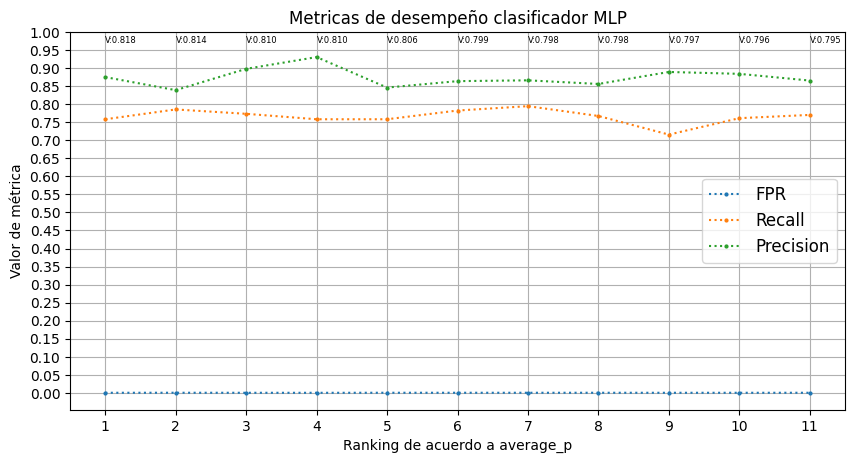

In [ ]:
#Metricas para N clasificadores MLP
show = 10
plot_metrics(pd.DataFrame(gs_MLP.cv_results_), clf_name="MLP", q=show)

In [ ]:
#Revision de mejores en Set de prueba

d_RF =  return_params(pd.DataFrame(gs_RF.cv_results_), 10)
d_MLP2 =  return_params(pd.DataFrame(gs_MLP.cv_results_), 2)
d_MLP4 =  return_params(pd.DataFrame(gs_MLP.cv_results_), 4)

d_rf = {**d_RF, **rf_d}
d_mlp2 = {**d_MLP2, **mlp_d}
d_mlp4 = {**d_MLP4, **mlp_d}

p_rf = Pipeline(steps=[sc,("svc",RandomForestClassifier(**d_rf))]).fit(X_train, y_train)
p_mlp2 = Pipeline(steps=[sc,("mlp2",MLPClassifier(**d_mlp2))]).fit(X_train, y_train)
p_mlp4 = Pipeline(steps=[sc,("mlp4",MLPClassifier(**d_mlp4))]).fit(X_train, y_train)


In [ ]:
#Metricas de cada clasificador en Test:

rf_pred = p_rf.predict(X_test)
mlp2_pred = p_mlp2.predict(X_test)
mlp4_pred = p_mlp4.predict(X_test)

prec_rf, rec_rf, av_rf, m_rf = show_metrics(y_test, rf_pred)
prec_mlp2, rec_mlp2, av_mlp2, m_mlp2 = show_metrics(y_test, mlp2_pred)
prec_mlp4, rec_mlp4, av_mlp4, m_mlp4 = show_metrics(y_test, mlp4_pred) 

print(f"### Clasificador 1 ###\nTipo: RandomForest\nParámetros:\n{d_RF}\nPrecisión: {prec_rf:.3f}\nRecall: {rec_rf:.3f}\nAverage Precision: {av_rf:.3f}\nMatriz de confusion:\n{m_rf}\n\n")
print(f"### Clasificador 2 ###\nTipo: MLP\nParámetros:\n{d_MLP2}\nPrecisión: {prec_mlp2:.3f}\nRecall: {rec_mlp2:.3f}\nAverage Precision: {av_mlp2:.3f}\nMatriz de confusion:\n{m_mlp2}\n\n")
print(f"### Clasificador 3 ###\nTipo: MLP\nParámetros:\n{d_MLP4}\nPrecisión: {prec_mlp4:.3f}\nRecall: {rec_mlp4:.3f}\nAverage Precision: {av_mlp4:.3f}\nMatriz de confusion:\n{m_mlp4}\n\n")


### Clasificador 1 ###
Tipo: RandomForest
Parámetros:
{'class_weight': {0: 1, 1: 1}, 'max_depth': 16, 'n_estimators': 30}
Precisión: 0.933
Recall: 0.782
Average Precision: 0.730
Matriz de confusion:
[[84968     8]
 [   31   111]]


### Clasificador 2 ###
Tipo: MLP
Parámetros:
{'activation': 'relu', 'hidden_layer_sizes': (20, 10)}
Precisión: 0.806
Recall: 0.789
Average Precision: 0.636
Matriz de confusion:
[[84949    27]
 [   30   112]]


### Clasificador 3 ###
Tipo: MLP
Parámetros:
{'activation': 'relu', 'hidden_layer_sizes': (20, 15)}
Precisión: 0.888
Recall: 0.782
Average Precision: 0.695
Matriz de confusion:
[[84962    14]
 [   31   111]]




# Conclusiones

Teniendo en cuenta que todos los modelos evaluados en el apartado final tienen un **Recall** muy similar, optaría por elegir el clasificador 1 (RandomForest) debido a:

*   Su **precisión** es mas alta que la de los otros dos modelos, por lo cual se generarán menos falsas alarmas que deban ser revisadas por los expertos en el area.

En general, se debería tener un **Recall** un poco más alto para este tipo de aplicación, ya que un FNR de 0.28 aún deja bastantes transacciones fraudulentas sin alertar, no obstante pudiese ser un buen punto de partida para posibles exploraciones venideras en el campo.



**Nota**
Correr celda siguiente sólo si se quiere ver comportamiento de algoritmo SVC con éste set de datos. Ejecución requiere mucho tiempo (más de 5h)

In [ ]:
#Pipeline y GridSearch para estimador: SVC 

data_svc.estimator = Pipeline(steps=[sc,("svc",SVC(random_state=123))])
data_svc.param_grid = {"svc__C": [10**x for x in range(-1,3)], #4 valores
                       "svc__kernel": ["linear"], #1 Valores
                       "svc__class_weight": [{1: w} for w in range(1, 200, 50)] #4valores
                       #"svc__gamma": [10**x for x in range(-1,3)] #4valores
                      }

print(f"Comienza\n")

gr = GridSearchCV(**data_svc.to_dict())
gr.fit(X_train, y_train)

print("\nTerminado")